![PandaLyze](https://github.com/Fluffy-Fatec/Projeto-Integrador-Imagem-Classificador/raw/develop/Imagens/pandalyzeheader.jpg)

# Challenge Description
At the heart of the digital age, where each interaction leaves a digital footprint, emerges the critical need to not only collect but deeply understand customer voices. Online reviews have become a treasure trove of insights, reflecting satisfaction, expectations, and sometimes disappointments of consumers. This project aims to go beyond mere data collection, proposing the construction of a sophisticated platform that integrates state-of-the-art sentiment analysis, storage in non-relational databases, and cutting-edge technology to decipher, map, and visualize these sentiments scattered across the digital world in a real and tangible geographic context.

This system will not only offer companies an accurate barometer of customer perception in different geographical areas but also enable a granular analysis of sentiment variations associated with local cultures, specific events, or product launches. By unraveling these complex and multifaceted patterns, companies will be able to adjust their marketing strategies, product development, and customer service with unprecedented precision, turning raw data into a directional compass for innovation and growth.

<b>Moreover, the application plans to employ advanced machine learning algorithms and natural language processing to not only classify reviews into basic sentiment categories but also to identify nuances and subtrends within these categories, offering an additional layer of insights. Combined with an intuitive user interface and a dynamic data visualization system, the project aims to create an invaluable tool for data-driven decision-making, allowing companies to visualize and react to customer feedback in real-time with detailed geographical resolution.</b>

The expectation is that this platform will become a fundamental instrument for companies seeking not only to survive but to thrive in the digital economy, proactively adapting to changes in customer perceptions and preferences. By providing a deep and actionable understanding of customer sentiment, this project aspires to inaugurate a new era of customer engagement, where decisions are driven by a holistic and geographically contextualized understanding of the customer experience.

This challenge represents a confluence of technology, data analysis, and business strategy, designed to equip companies with the knowledge necessary to anticipate customer needs, optimize user experience, and ultimately forge a stronger and more meaningful bond with their consumers worldwide.

# 1. Install PIP's

In [2]:
%pip install unidecode
%pip install spacy
%pip install seaborn
%pip install nltk
%pip install stats
%pip install xgboost
%pip install sweetviz
%pip install string
%pip install imblearn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement string (from versions: none)
ERROR: No matching distribution found for string


Note: you may need to restart the kernel to use updated packages.


# 2. Import Packages

In [3]:
import pandas as pd
import spacy
nlp = spacy.load('pt_core_news_lg')
import string
import regex as re
from unidecode import unidecode
import joblib
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt

# 3. Load Data

In [4]:
customers_df = pd.read_csv("olist_customers_dataset.csv")
geolocation_df = pd.read_csv("olist_geolocation_dataset.csv")
order_items_df = pd.read_csv("olist_order_items_dataset.csv")
order_payments_df = pd.read_csv("olist_order_payments_dataset.csv")
order_reviews_df = pd.read_csv("olist_order_reviews_dataset.csv")
orders_df = pd.read_csv("olist_orders_dataset.csv")
products_df = pd.read_csv("olist_products_dataset.csv")
sellers_df = pd.read_csv("olist_sellers_dataset.csv")
product_category_name_translation_df = pd.read_csv("product_category_name_translation.csv")

# 4. Data Wreangling

### 4.1. Merge Data

In [5]:
df = orders_df.merge(order_reviews_df, on='order_id')\
                   .merge(order_items_df, on='order_id')\
                   .merge(products_df, on='product_id')\
                   .merge(sellers_df, on='seller_id')\
                   .merge(geolocation_df, left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix')

### 4.2. Selected Columns Important

In [6]:
selected_columns = ['review_id', 'review_score', 
                    'review_comment_message', 'review_creation_date', 
                    'geolocation_lat', 'geolocation_lng','geolocation_state']

full_df = df.loc[:, selected_columns]

### 4.3. Conversion Columns Data in datetime

In [7]:
datetime_columns = ['review_creation_date']
full_df[datetime_columns] = full_df[datetime_columns].apply(pd.to_datetime)

### 4.4. Drop Duplicates

In [8]:
full_df = full_df.drop_duplicates(subset=['review_id'])

### 4.5. Drop NA

In [9]:
full_df = full_df.dropna(subset=['review_comment_message'])
full_df = full_df.dropna(subset=['review_score'])

### 4.6. Separeting Last Month for Test

In [10]:
latest_date = full_df['review_creation_date'].max()
four_months_ago = latest_date - pd.DateOffset(months=1)


full_df = full_df[full_df['review_creation_date'] >= four_months_ago]
full_df.reset_index(drop=True, inplace=True)

# 5. Data Processing

### 5.1. Conversion Column Message in Lower Case

In [11]:
def to_lower(text):
    return text.lower()

In [12]:
full_df['text_sentiment'] = full_df['review_comment_message'].apply(to_lower)

### 5.2. Removing Punctuation, Exemple (".", "!")

In [13]:
def remove_punctuation(text):
    punct = string.punctuation
    punct = punct.replace("'", "")
    translator = str.maketrans('', '', punct)
    return text.translate(translator)

In [14]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(remove_punctuation)

### 5.3. Removing Emoji

In [15]:
def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # simbol and pictogramas
                               u"\U0001F680-\U0001F6FF"  # transport and ]simbol of map
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [16]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(remove_emojis)

### 5.4. Removing Sites and Blogs

In [17]:
def remove_urls(text):
    http = r"http\S+|www\.\S+"
    pattern = re.compile(r"({})".format(http))
    return pattern.sub(r'', text)

In [18]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(remove_urls)

### 5.5. Removing Accentuation

In [19]:
def remove_accent(text):
    return unidecode(text)

In [20]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(remove_accent)

### 5.6. Remove Numbers

In [21]:
def remove_numbers(texto):
    return re.sub(r'\d+', '', texto)

In [22]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(remove_numbers)

### 5.7. Remove Space Blank Excessive and Remove Broke Line

In [23]:
def remove_broke_line(texto):
    return texto.replace('\n', ' ')

In [24]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(remove_broke_line)

### 5.8. Remove Blank Space Text

In [25]:
def strip_text(text):
    return text.strip()

In [26]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(strip_text)

### 5.9. Filter only Adjetivos, Verbos, Substantivo, Adverbios and "nao" "nada"

In [27]:
def filtrar_tokens(text):
    doc = nlp(text)
    tokens_filtrados = []
    for token in doc:
        if token.text.lower() == 'nao':
            tokens_filtrados.append(token.text)
        elif token.text.lower() == 'nada':
            tokens_filtrados.append(token.text)
        elif token.pos_ in ['ADJ', 'VERB', 'NOUN', 'ADV']:
            tokens_filtrados.append(token.text)
    return ' '.join(tokens_filtrados)

In [28]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(filtrar_tokens)

### 5.10. Lematization Example: "entrega" change for "entregar"

In [29]:
def lemmatize_text(text):
    return " ".join([token.lemma_ for token in nlp(text)])

In [30]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(lemmatize_text)

### 5.11. Drop NA

In [31]:
full_df = full_df.dropna(subset=['text_sentiment'])

In [32]:
print(len(full_df))

3576


In [33]:
full_df.head(5)

,review_id,review_score,review_comment_message,review_creation_date,geolocation_lat,geolocation_lng,geolocation_state,text_sentiment
0,8d5266042046a06655c8db133d120ba5,4,Muito bom o produto.,2018-08-08,-19.810119,-43.984727,MG,muito bom produto
1,9a55cbc65c8fad47581da5ebbb2b373e,5,Sempre vou comprar aqui pois é a melhor parabéns,2018-08-14,-21.728866,-48.688815,SP,sempre comprar aqui pois bom parabens
2,7fe86452ea24bb5085343b5e9d684a3e,5,Prazo de entrega excelente e produto cuidadosa...,2018-08-03,-23.615718,-46.531184,SP,prazo entregar excelente produto cuidadosament...
3,25b502beeef8b3aff87449ccdc001f53,1,"Recebi apenas 1 unidade solicitada, deveriam s...",2018-08-01,-23.661487,-46.564162,SP,recebi apenas unidade solicitar dever inclusiv...
4,eec56fe350a345430c241eec25016592,5,"Produto muito bonito, chegou no prazo correto ...",2018-08-29,-23.693986,-46.701883,SP,produto muito bonito chegar prazo correto pare...


# 6. Previus Analyze

In [34]:
def df_metadata(df):
    metadata = pd.DataFrame(df.dtypes,columns=['dtypes'])
    metadata = metadata.reset_index()
    metadata['Column'] = metadata['index']
    metadata = metadata[['Column','dtypes']]
    metadata['# Missing'] = df.isnull().sum().values    
    metadata['# Unique'] = df.nunique().values
    metadata['Example'] = df.loc[0].values

    return metadata
    
df_metadata(full_df)

,Column,dtypes,# Missing,# Unique,Example
0,review_id,object,0,3576,8d5266042046a06655c8db133d120ba5
1,review_score,int64,0,5,4
2,review_comment_message,object,0,3363,Muito bom o produto.
3,review_creation_date,datetime64[ns],0,31,2018-08-08 00:00:00
4,geolocation_lat,float64,0,858,-19.810119
5,geolocation_lng,float64,0,858,-43.984727
6,geolocation_state,object,0,16,MG
7,text_sentiment,object,0,3048,muito bom produto


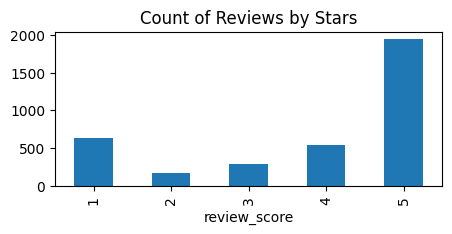

In [35]:
ax = full_df['review_score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(5,2))

In [36]:
example = full_df['text_sentiment'].iloc[4]
print(example)

produto muito bonito chegar prazo correto parecer trofeu qualidade otimo presente


# 7. Deploy Dataframe Test

### 7.1. Selecting Columns

In [37]:
selected_columns = ['text_sentiment']
df_test = full_df.loc[:, selected_columns]

In [38]:
df_test.head(5)

,text_sentiment
0,muito bom produto
1,sempre comprar aqui pois bom parabens
2,prazo entregar excelente produto cuidadosament...
3,recebi apenas unidade solicitar dever inclusiv...
4,produto muito bonito chegar prazo correto pare...


### 7.2. Loading Deploy IA

In [40]:
analyze_sentiment = joblib.load('Deploy/modelo_analyze_sentiment.pkl')
vectorizer = joblib.load('Deploy/vectorizer.pkl')
normalization = joblib.load('Deploy/normalization.pkl')

### 7.3. Inicializing Test IA with DF Test

In [41]:
pd.set_option('display.max_colwidth', None)

comment_test_dtm = vectorizer.transform(df_test['text_sentiment'])
X_test = normalization.transform(comment_test_dtm)

predictions = analyze_sentiment.predict(X_test)

df_test['predictions'] = predictions

display(df_test[['text_sentiment', 'predictions']])

,text_sentiment,predictions
0,muito bom produto,1
1,sempre comprar aqui pois bom parabens,1
2,prazo entregar excelente produto cuidadosamente embalar recomender,1
3,recebi apenas unidade solicitar dever inclusive cobrar constar nota fiscal tentar contato loja dia informar mandar email contato fornecer,0
4,produto muito bonito chegar prazo correto parecer trofeu qualidade otimo presente,1
...,...,...
3571,ainda nao chegar nao com si rastrear produto preciso codigo rastreamento,0
3572,vir td certo chegar mt antes certeza comprar novamente,1
3573,achar produto muito pequeno ficar tela botoes microondas sair facilidade nao ter bom encaixe,1
3574,muito bom produto,1


### 7.4. Export DF

In [43]:
df_export = full_df.copy()
df_export['predictions'] = predictions
df_export[['review_id','review_comment_message','text_sentiment', 'review_score', 'predictions','geolocation_lat','geolocation_lng','geolocation_state','review_creation_date']].to_csv('dados_processados.csv', index=False)

In [44]:
df_export.head(5)

,review_id,review_score,review_comment_message,review_creation_date,geolocation_lat,geolocation_lng,geolocation_state,text_sentiment,predictions
0,8d5266042046a06655c8db133d120ba5,4,Muito bom o produto.,2018-08-08,-19.810119,-43.984727,MG,muito bom produto,1
1,9a55cbc65c8fad47581da5ebbb2b373e,5,Sempre vou comprar aqui pois é a melhor parabéns,2018-08-14,-21.728866,-48.688815,SP,sempre comprar aqui pois bom parabens,1
2,7fe86452ea24bb5085343b5e9d684a3e,5,Prazo de entrega excelente e produto cuidadosamente embalado! Recomendo!,2018-08-03,-23.615718,-46.531184,SP,prazo entregar excelente produto cuidadosamente embalar recomender,1
3,25b502beeef8b3aff87449ccdc001f53,1,"Recebi apenas 1 unidade solicitada, deveriam ser 2, inclusive foi cobrado e consta na nota fiscal. Estou tentando contato com a loja a 4 dias. Informam que vão me mandar por email o contato do fornece",2018-08-01,-23.661487,-46.564162,SP,recebi apenas unidade solicitar dever inclusive cobrar constar nota fiscal tentar contato loja dia informar mandar email contato fornecer,0
4,eec56fe350a345430c241eec25016592,5,"Produto muito bonito, chegou no prazo correto parece um Trofeu, qualidade ótimo para presente",2018-08-29,-23.693986,-46.701883,SP,produto muito bonito chegar prazo correto parecer trofeu qualidade otimo presente,1


# 8. Analyze Test DF

### 8.1. Cloud Word

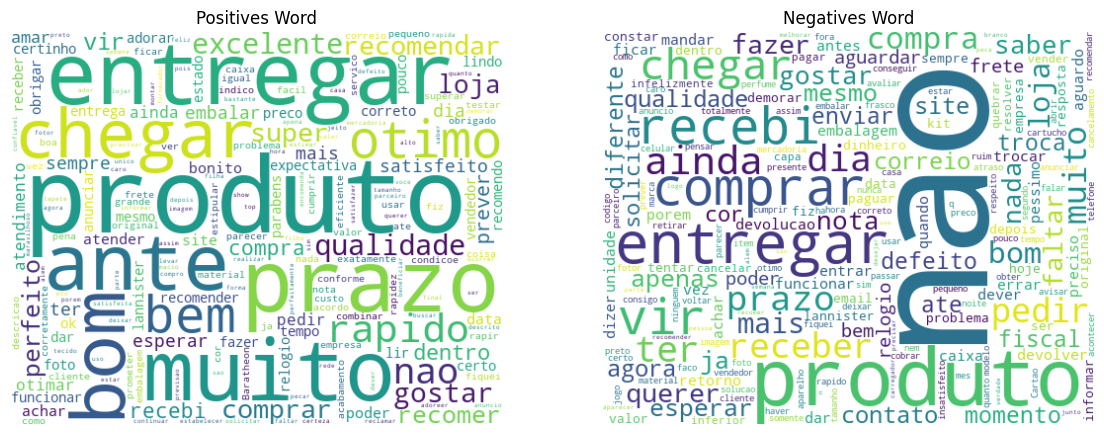

In [45]:
Most_Positive_text = ' '.join(df_export[df_export['predictions'] == 1]['text_sentiment'])
Most_Negative_text = ' '.join(df_export[df_export['predictions'] == 0]['text_sentiment'])

pwc = WordCloud(width=500, height=400, collocations=False, background_color='white').generate(Most_Positive_text)
nwc = WordCloud(width=500, height=400, collocations=False, background_color='white').generate(Most_Negative_text)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.imshow(pwc, interpolation='bilinear')
plt.title('Positives Word', fontsize=12)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(nwc, interpolation='bilinear')
plt.title('Negatives Word', fontsize=12)
plt.axis('off')

plt.show()

### 8.2. Top 10 Words Negative and Positive

In [46]:
mensagens_positivas = df_export[df_export['predictions'] == 1]['text_sentiment']
mensagens_negativas = df_export[df_export['predictions'] == 0]['text_sentiment']

def contar_palavras(mensagens, sentiment):
    todas_mensagens = ' '.join(mensagens)
    palavras = todas_mensagens.split()
    contagem_palavras = Counter(palavras)
    
    # Criando o DataFrame
    df_contagem = pd.DataFrame(contagem_palavras.most_common(60), columns=['word', 'count'])
    df_contagem['sentiment'] = sentiment
    return df_contagem

df_positivas = contar_palavras(mensagens_positivas, 1)
df_negativas = contar_palavras(mensagens_negativas, 0)

In [47]:
df_positivas.head(10)

,word,count,sentiment
0,produto,1002,1
1,entregar,647,1
2,prazo,641,1
3,muito,606,1
4,antes,515,1
5,bom,467,1
6,chegar,385,1
7,otimo,247,1
8,bem,243,1
9,rapido,226,1


In [48]:
df_negativas.head(10)

,word,count,sentiment
0,nao,769,0
1,produto,656,0
2,entregar,296,0
3,comprar,234,0
4,recebi,222,0
5,vir,213,0
6,chegar,152,0
7,ainda,134,0
8,dia,112,0
9,ter,110,0
